Liz Rightmire

N1 Health Challenge

November 2024

In [88]:
import pandas as pd
import matplotlib
import geopandas as gpd
import geodatasets
from shapely.geometry import Point
import matplotlib.pyplot as plt

# Data

In [89]:
cities = pd.read_csv("Datasets/500cities/500cities.csv")
cities.head()

,StateAbbr,PlaceName,PlaceFIPS,TractFIPS,Place_TractID,Population2010,ACCESS2_CrudePrev,ACCESS2_Crude95CI,ARTHRITIS_CrudePrev,ARTHRITIS_Crude95CI,...,PAPTEST_Crude95CI,PHLTH_CrudePrev,PHLTH_Crude95CI,SLEEP_CrudePrev,SLEEP_Crude95CI,STROKE_CrudePrev,STROKE_Crude95CI,TEETHLOST_CrudePrev,TEETHLOST_Crude95CI,Geolocation
0,AL,Birmingham,107000,1073000100,0107000-01073000100,3042,24.4,"(21.2, 27.8)",31.2,"(30.1, 32.2)",...,"(83.4, 86.6)",20.5,"(18.9, 22.2)",45.5,"(44.3, 46.5)",5.5,"( 5.0, 5.9)",28.9,"(23.7, 35.1)","(33.57943283260, -86.7228323926)"
1,AL,Birmingham,107000,1073000300,0107000-01073000300,2735,30.4,"(27.1, 33.7)",30.5,"(29.3, 31.7)",...,"(81.9, 85.6)",22.2,"(20.4, 24.0)",44.5,"(43.2, 45.7)",6.1,"( 5.5, 6.8)",32.9,"(25.5, 40.2)","(33.54282086860, -86.7524339780)"
2,AL,Birmingham,107000,1073000400,0107000-01073000400,3338,24.7,"(21.1, 28.5)",31.5,"(30.2, 32.9)",...,"(82.3, 86.8)",19.4,"(17.5, 21.4)",45.7,"(44.2, 47.0)",5.6,"( 5.0, 6.2)",28.6,"(22.0, 35.1)","(33.56324496330, -86.7640474064)"
3,AL,Birmingham,107000,1073000500,0107000-01073000500,2864,25.2,"(21.6, 29.0)",35.0,"(33.5, 36.4)",...,"(82.1, 86.5)",21.7,"(19.7, 23.9)",46.1,"(44.5, 47.4)",7.3,"( 6.5, 8.2)",34.0,"(24.4, 42.9)","(33.54424045940, -86.7749130719)"
4,AL,Birmingham,107000,1073000700,0107000-01073000700,2577,29.0,"(24.5, 33.8)",36.3,"(34.9, 37.7)",...,"(82.2, 87.1)",25.5,"(23.1, 28.0)",48.3,"(46.6, 49.7)",9.0,"( 8.1, 10.0)",43.2,"(33.2, 53.2)","(33.55254061390, -86.8016893706)"


In [90]:
StateAndCounty = pd.read_csv("Datasets/FoodEnvironmentAtlas/StateAndCountyData.csv")
StateAndCounty.head()

,FIPS,State,County,Variable_Code,Value
0,1001,AL,Autauga,LACCESS_POP10,18428.439690
1,1001,AL,Autauga,LACCESS_POP15,17496.693040
2,1001,AL,Autauga,PCH_LACCESS_POP_10_15,-5.056026
3,1001,AL,Autauga,PCT_LACCESS_POP10,33.769657
4,1001,AL,Autauga,PCT_LACCESS_POP15,32.062255


In [91]:
populations = pd.read_csv("Datasets/FoodEnvironmentAtlas/SupplementalDataCounty.csv")
populations.head()

,FIPS,State,County,Variable_Code,Value
0,1001,AL,Autauga County,2010_Census_Population,54571
1,1001,AL,Autauga County,Population_Estimate_2011,55208
2,1001,AL,Autauga County,Population_Estimate_2012,54936
3,1001,AL,Autauga County,Population_Estimate_2013,54713
4,1001,AL,Autauga County,Population_Estimate_2014,54876


In [92]:
unique_codes = populations['Variable_Code'].unique()
unique_codes

array(['2010_Census_Population', 'Population_Estimate_2011',
       'Population_Estimate_2012', 'Population_Estimate_2013',
       'Population_Estimate_2014', 'Population_Estimate_2015',
       'Population_Estimate_2016', 'Population_Estimate_2017',
       'Population_Estimate_2018'], dtype=object)

In [93]:
Variables = pd.read_csv("Datasets/FoodEnvironmentAtlas/VariableList.csv")
Variables

,Variable_Name,Category_Name,Category_Code,Subcategory_Name,Variable_Code,Geography,Units
0,"Population, low access to store, 2010",Access and Proximity to Grocery Store,ACCESS,Overall,LACCESS_POP10,CNTY10,Count
1,"Population, low access to store, 2015",Access and Proximity to Grocery Store,ACCESS,Overall,LACCESS_POP15,CNTY10,Count
2,"Population, low access to store (% change), 20...",Access and Proximity to Grocery Store,ACCESS,Overall,PCH_LACCESS_POP_10_15,CNTY10,% change
3,"Population, low access to store (%), 2010",Access and Proximity to Grocery Store,ACCESS,Overall,PCT_LACCESS_POP10,CNTY10,Percent
4,"Population, low access to store (%), 2015",Access and Proximity to Grocery Store,ACCESS,Overall,PCT_LACCESS_POP15,CNTY10,Percent
...,...,...,...,...,...,...,...
276,"Persistent-poverty counties, 2010",Socioeconomic Characteristics,SOCIOECONOMIC,Income Level,PERPOV10,CNTY10,Legend
277,"Child poverty rate, 2015",Socioeconomic Characteristics,SOCIOECONOMIC,Income Level,CHILDPOVRATE15,CNTY10,Percent
278,"Persistent-child-poverty counties, 2010",Socioeconomic Characteristics,SOCIOECONOMIC,Income Level,PERCHLDPOV10,CNTY10,Legend
279,"Metro/nonmetro counties, 2010",Socioeconomic Characteristics,SOCIOECONOMIC,Other,METRO13,CNTY10,Legend


In [94]:
#print(cities['Geolocation'].head(10))
#print(cities.dtypes)


In [95]:
# Remove parentheses and split into latitude and longitude
#cities['Geolocation'] = cities['Geolocation'].str.strip("()")
#cities[['latitude', 'longitude']] = cities['Geolocation'].str.split(", ", expand=True).astype(float)


In [96]:
# Clean and preprocess Geolocation
#cities['Geolocation'] = cities['Geolocation'].str.strip("()")
#cities['Geolocation'] = cities['Geolocation'].apply(lambda x: tuple(map(float, x.split(", "))))
#cities['latitude'] = cities['Geolocation'].apply(lambda x: x[0])
#cities['longitude'] = cities['Geolocation'].apply(lambda x: x[1])

#print(cities.head())

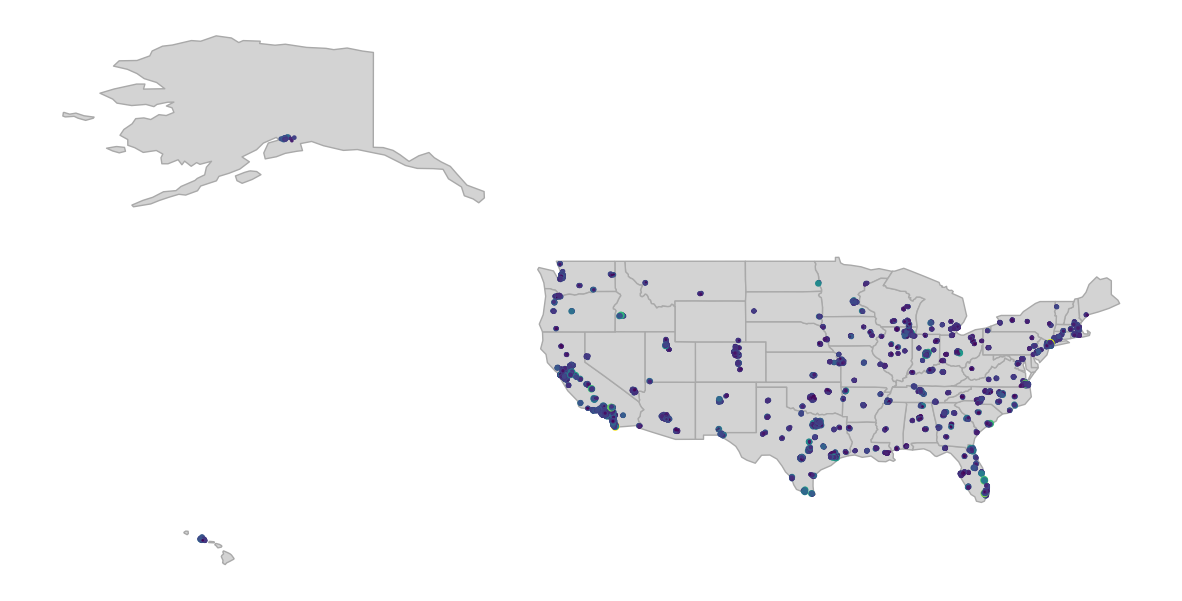

In [97]:
# Clean and preprocess Geolocation
cities['Geolocation'] = cities['Geolocation'].str.strip("()")
cities['Geolocation'] = cities['Geolocation'].apply(lambda x: tuple(map(float, x.split(", "))))
cities['latitude'] = cities['Geolocation'].apply(lambda x: x[0])
cities['longitude'] = cities['Geolocation'].apply(lambda x: x[1])

# Create Point geometry
cities['geometry'] = cities.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

# Load the dataset
states = gpd.read_file("states/states.shp")

# Convert cities DataFrame into a GeoDataFrame
gdf = gpd.GeoDataFrame(cities, geometry='geometry')

# Plot the USA map and overlay the population data
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot USA boundaries
states.plot(ax=ax, color='lightgray', edgecolor='darkgrey')

# Overlay the cities data
gdf.plot(column='Population2010', 
         cmap='viridis', 
         legend=False, 
         ax=ax,
         markersize=gdf['Population2010'] / 1000)  # Adjust marker size by population

# Customize the plot

plt.axis("off")  # Hide axes
plt.show()


In [98]:
#print(cities['Geolocation'].head())
#print(cities['Geolocation'].dtype)

0    (33.5794328326, -86.7228323926)
1     (33.5428208686, -86.752433978)
2    (33.5632449633, -86.7640474064)
3    (33.5442404594, -86.7749130719)
4    (33.5525406139, -86.8016893706)
Name: Geolocation, dtype: object
object


simple map

<Axes: >

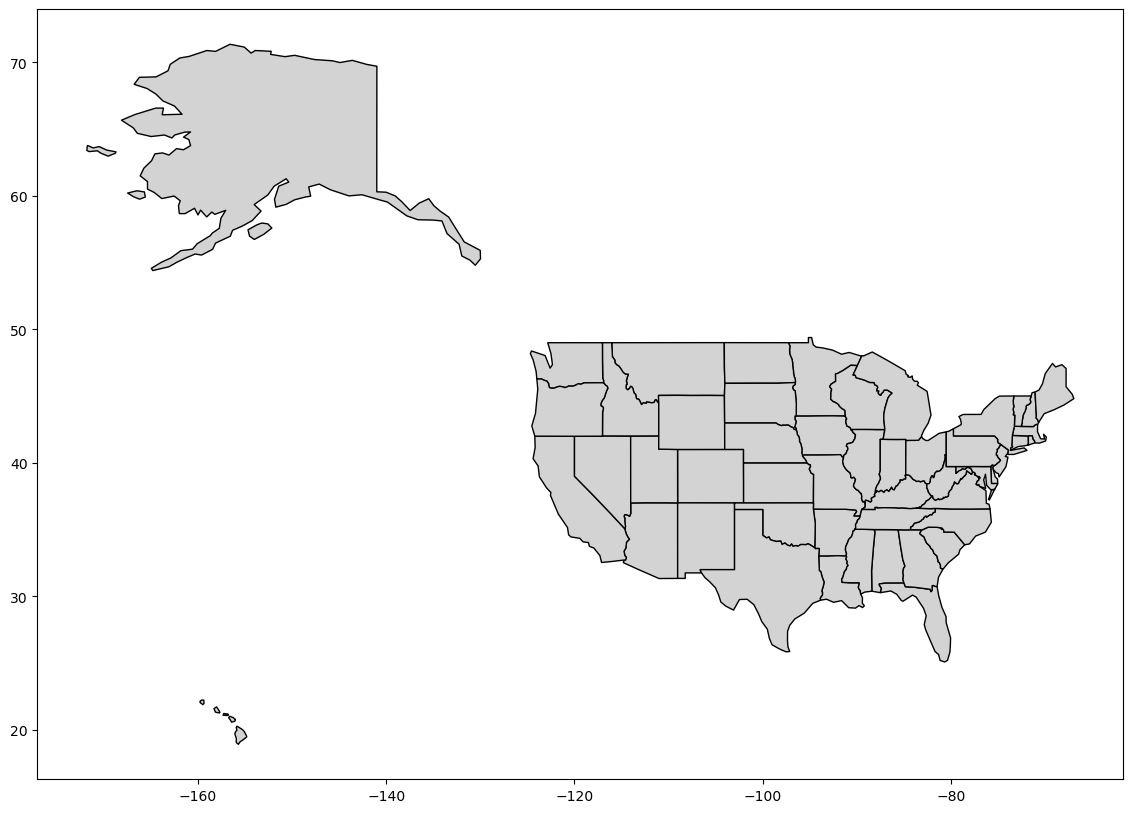

In [99]:
import geopandas as gpd 

# Load the dataset
states = gpd.read_file("states/states.shp")

# Plot the USA map and overlay the population data
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot USA boundaries
states.plot(ax=ax, color='lightgray', edgecolor='black')